Here we load GBTIDL spectra saved as ASCII's and try to fit the baseline structure using multiple methods. This work was motivated by the difficult baseline structure in the 100m telescope, caused by multipath scattering in the actuator gaps.

This one is just on 108 + 3! (Can we get the CO ascii for this too?)

First we do Ridge Regression (see LSST Hack Day slide--Session 10).

Then we'll try Gaussian Processes (see LSST Session 9) and/or Fourier Filtering.

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import ascii
import celerite

In [239]:
%matplotlib inline

In [73]:
# Load the Fits file:

OHdata = ascii.read('1083-13hr-vel-smoothed-centered.ascii', data_start=3, names=['VEL (km/s)', 'Ta (K)'])

In [246]:
# Chop off the sides of the bandpass:
vel = OHdata['VEL (km/s)']
Ta = OHdata['Ta (K)']

igood = np.where((vel >= -500) & (vel <= 1000))

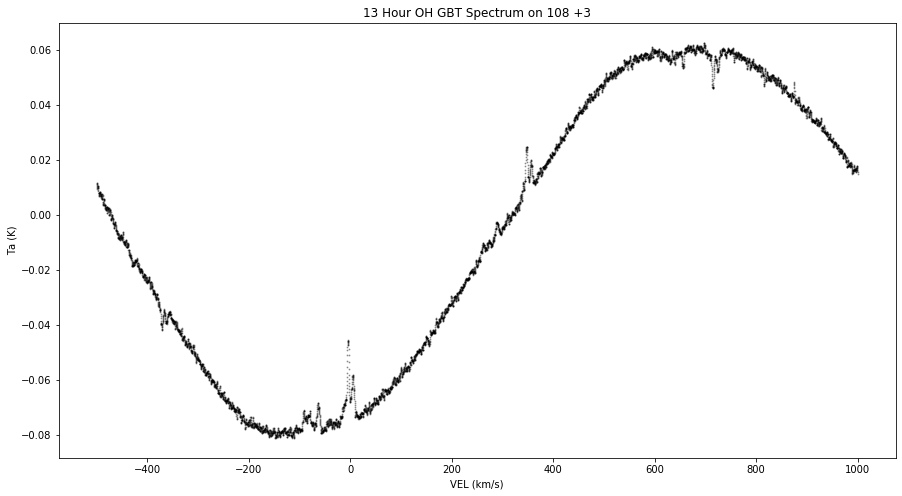

In [247]:
# Plot the data:
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(freq[igood], Ta[igood], 'k.', alpha=0.3, ms=2)
ax.set_title('13 Hour OH GBT Spectrum on 108 +3')
ax.set_ylabel("Ta (K)")
ax.set_xlabel("VEL (km/s)");

(-200, 50)

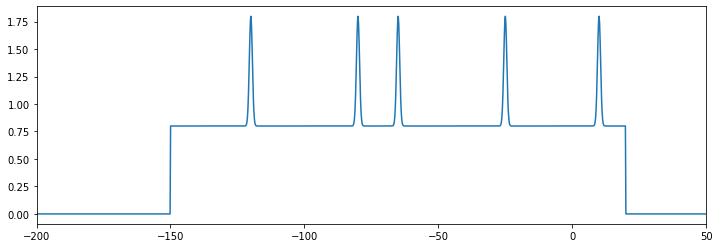

In [248]:
# Make a cheap model for the outer galaxy the velocities:
# 10,-25,-65,-80,-120 correspond to: Local, Inter-Arm, Perseus, Outer Arm, Outer-Scutum Crux Arm, for 1667 eission.
# Velocities where 1665 is? Will need to get from GBTIDL:

x = vel[igood]
y = Ta[igood]

# Model for OH emission in outer galaxy 1667:
vel1 = 10
vel2 = -25
vel3 = -65
vel4 = -80
vel5 = -120
sig = 0.8

# Model for OH emission in outer galaxy 1665:
vel6 = 350
vel7 = 320
vel8 = 289
vel9 = 258
vel10 = 230

# RFI?
vel11 = -365
vel12 = -631
vel13 = 720

# The tophat for the 1667 line:
tophat1667 = 0.8 * np.ones_like(x)
tophat1667[x < -150] = 0
tophat1667[x > 20] = 0

# The tophat for the 1665 line:
tophat1665 = 0.8 * np.ones_like(x)
tophat1665[x < 210] = 0
tophat1665[x > 360] = 0

emission_model = np.exp(-(x - vel1) ** 2 / sig ** 2) \
                + np.exp(-(x - vel2) ** 2 / sig ** 2) \
                + np.exp(-(x - vel3) ** 2 / sig ** 2) \
                + np.exp(-(x - vel4) ** 2 / sig ** 2) \
                + np.exp(-(x - vel5) ** 2 / sig ** 2) \
                + tophat1667 \

fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(x, emission_model);
ax.set_xlim([-200, 50])

In [249]:
# Create the code to do setup 500 regressors:
nreg = 100
log_lam = 10

# Compute the weights
t = (x - x[0]) / (x[-1] - x[0]) - 0.5
A = np.vander(t, nreg, increasing=True)
C = A.T.dot(A)
C[np.diag_indices_from(C)] += 1.0 / 10 ** log_lam
w = np.linalg.solve(C, A.T.dot(y))

# Compute the weights
Anew = np.hstack((A, emission_model.reshape(-1, 1)))
    
# L2-regularized fit
lam = 1e4
C = Anew.T.dot(Anew)
C[np.diag_indices_from(C)] += np.append(1.0 / lam * np.ones(nreg), 0.0)
wnew = np.linalg.solve(C, Anew.T.dot(y))
    
# Separate into systematics and emission weights
w = wnew[:-1]
depth = wnew[-1]

# The depth uncertainty
depth_err = np.sqrt(np.diag(np.linalg.inv(C))[-1])
    
# The systematics model
model = A.dot(w)

Text(0.5, 1.0, 'OH Spectrum Towards Outer Galaxy: Polynomial order: 100')

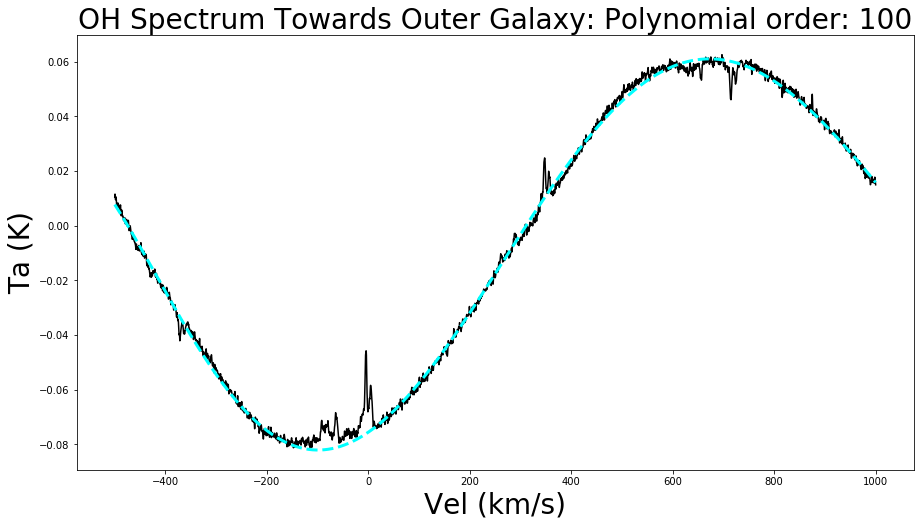

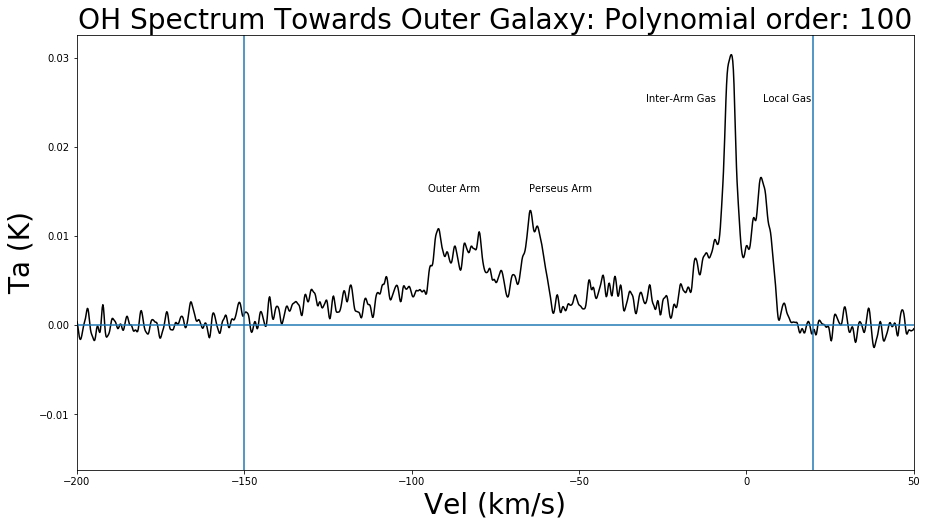

In [250]:
# Plot the fit and the residuals:

# Plot it!
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y, 'k')
ax.plot(x, model, color='cyan', lw=3, linestyle='--')
ax.set_xlabel("Vel (km/s)", fontsize=28)
ax.set_ylabel("Ta (K)", fontsize=28)
ax.set_title("OH Spectrum Towards Outer Galaxy: Polynomial order: %d" % nreg, fontsize=28)

fig, ax = plt.subplots(1, figsize=(15, 8))
ax.plot(x, y - model, 'k')
#ax.plot(x_, model_, color='cyan', lw=3, linestyle='--')
ax.set_xlabel("Vel (km/s)", fontsize=28)
ax.set_ylabel("Ta (K)", fontsize=28)
#ax.set_ylim([-0.1, 0.1])
ax.set_xlim([-200, 50])
ax.annotate('Local Gas', (5, 0.025))
ax.annotate('Inter-Arm Gas', (-30, 0.025))
ax.annotate('Perseus Arm', (-65, 0.015))
ax.annotate('Outer Arm', (-95, 0.015))
ax.axhline(0)
ax.axvline(-150)
ax.axvline(20)
ax.set_title("OH Spectrum Towards Outer Galaxy: Polynomial order: %d" % nreg, fontsize=28)

In [139]:
# Create two subplots, one for the HI and one for the CO:

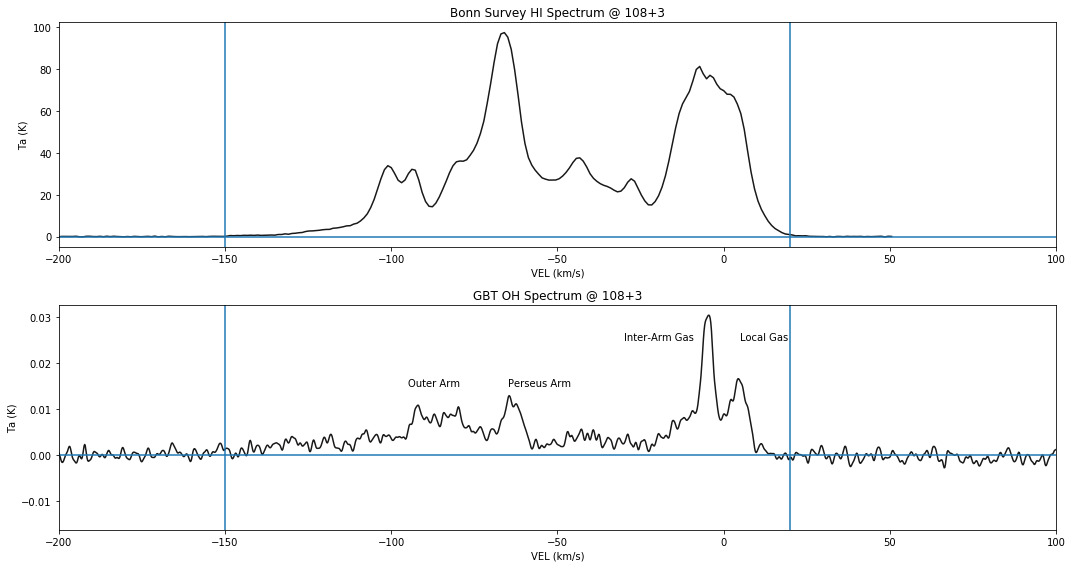

In [278]:
# Load the HI Fits file:
HIdata = ascii.read('HISpectrum.txt', names=['VEL (km/s)', 'Ta (K)'])

HIfreq = HIdata['VEL (km/s)']
HITa = HIdata['Ta (K)']

# Plot the data:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

# Plot the HI:
ax1.plot(HIfreq, HITa, 'k', alpha=0.9, ms=2)
ax1.axhline(0)
ax1.axvline(-150)
ax1.axvline(20)
ax1.set_xlim([-200, 100])
ax1.set_title('Bonn Survey HI Spectrum @ 108+3')
ax1.set_ylabel("Ta (K)")
ax1.set_xlabel("VEL (km/s)");

# Plot the OH:
ax2.plot(x, y-model, 'k', alpha=0.9, ms=2)
ax2.axhline(0)
ax2.axvline(-150)
ax2.axvline(20)
ax2.set_xlim([-200, 100])
ax2.annotate('Local Gas', (5, 0.025))
ax2.annotate('Inter-Arm Gas', (-30, 0.025))
ax2.annotate('Perseus Arm', (-65, 0.015))
ax2.annotate('Outer Arm', (-95, 0.015))
ax2.set_title('GBT OH Spectrum @ 108+3')
ax2.set_ylabel("Ta (K)")
ax2.set_xlabel("VEL (km/s)");

# Plot the CO:


fig.tight_layout()